/home/ad/22021468/miniconda3/envs/IndustryExperience/lib/python3.9/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict 

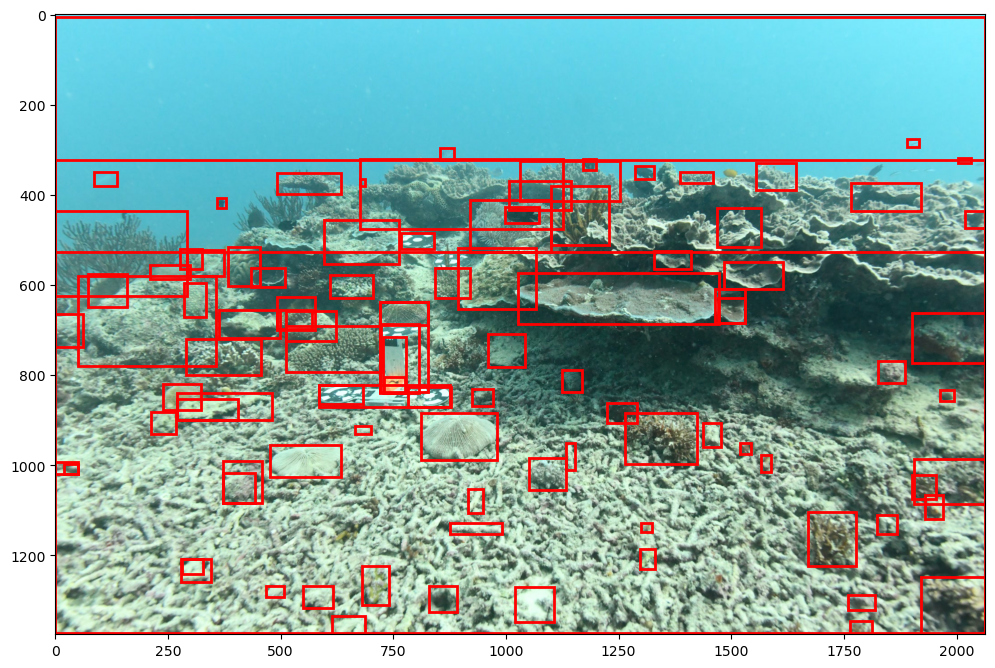

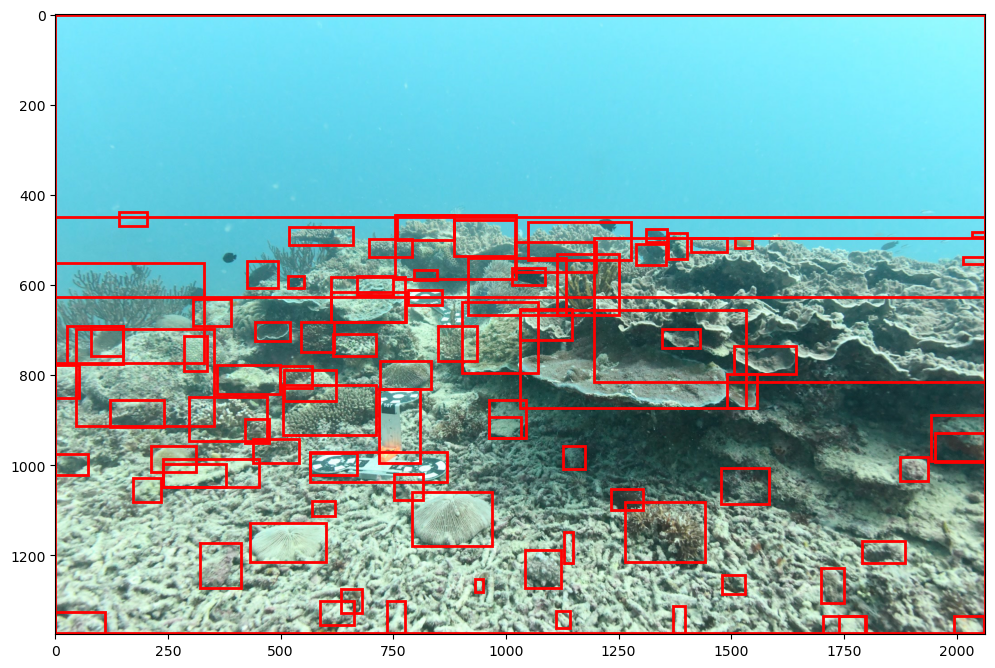

Segmentation complete for all images.


In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import supervision as sv

class ModelLoader:
    def __init__(self, model_type: str, checkpoint_path: str, device: torch.device):
        self.model_type = model_type
        self.checkpoint_path = checkpoint_path
        self.device = device
        self.model = self.load_model()

    def load_model(self):
        sam = sam_model_registry[self.model_type](checkpoint=self.checkpoint_path)
        sam.to(device=self.device)
        return sam

class MaskGenerator:
    def __init__(self, sam_model):
        self.mask_generator = SamAutomaticMaskGenerator(sam_model)

    def generate_masks(self, image_rgb: np.ndarray):
        return self.mask_generator.generate(image_rgb)

class ImageProcessor:
    def __init__(self, image_path: str):
        self.image_path = image_path
        self.image_bgr = cv2.imread(image_path)
        self.image_rgb = cv2.cvtColor(self.image_bgr, cv2.COLOR_BGR2RGB)

class BoundingBoxDrawer:
    @staticmethod
    def draw_bounding_boxes(anns, image_bgr):
        if len(anns.xyxy) == 0:
            return
        
        areas = (anns.xyxy[:, 2] - anns.xyxy[:, 0]) * (anns.xyxy[:, 3] - anns.xyxy[:, 1])
        sorted_anns = sorted(zip(anns.xyxy, areas), key=lambda x: x[1], reverse=True)
        
        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))

        for ann, area in sorted_anns:
            x1, y1, x2, y2 = ann
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2))

        plt.show()

class AnnotationDisplay:
    def __init__(self):
        self.mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.CLASS)

    def show_annotations(self, masks, image_bgr):
        detections = sv.Detections.from_sam(masks)
        BoundingBoxDrawer.draw_bounding_boxes(detections, image_bgr)

class SegmentationPipeline:
    def __init__(self, model_type, checkpoint_path, device, image_paths):
        self.model_loader = ModelLoader(model_type, checkpoint_path, device)
        self.mask_generator = MaskGenerator(self.model_loader.model)
        self.annotation_display = AnnotationDisplay()
        self.image_paths = image_paths

    def run_pipeline(self):
        for image_path in self.image_paths:
            image_processor = ImageProcessor(image_path)
            masks = self.mask_generator.generate_masks(image_processor.image_rgb)
            self.annotation_display.show_annotations(masks, image_processor.image_bgr)
        print("Segmentation complete for all images.")

# Setup
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/home/ad/22021468/sam_checkpoints/sam_vit_h_4b8939.pth"
IMAGE_PATHS = [
    "/data/shared/CSIT_Placement_2025_3D_Reef/CBHE_BA2D_P1/images/frame_00001.JPG",
    "/data/shared/CSIT_Placement_2025_3D_Reef/CBHE_BA2D_P1/images/frame_00002.JPG",
]

# Run the segmentation pipeline
segmentation_pipeline = SegmentationPipeline(MODEL_TYPE, CHECKPOINT_PATH, DEVICE, IMAGE_PATHS)
segmentation_pipeline.run_pipeline()
